In [9]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

In [10]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
#
# Real ticker data
#
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

box_size = 2

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

column_flag = None

reversal_value = box_size * 2

reversal_flag = False

column_index = 0

# Simple point and figure algorihtm


for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start

        # First of all we need to set box size.
        # Then calculate price movement.
        # If price movement is more or equal than box size - renko bar(or bars) will be added

        if np.abs(price_move) >= box_size:

            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much pnf boxes will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_date = df.close.index[i]

            if column_flag == 'x' and reversal_flag == False:

                # Reversal check
                if price_move < 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move > 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == 'o' and reversal_flag == False:

                # Reversal check
                if price_move > 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move < 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == None and reversal_flag == False:

                # Adding first column

                if price_move > 0:
                    column_flag = 'x'

                if price_move < 0:
                    column_flag = 'o'

                for b in range(int(box_quantity)):
                    if column_flag == 'x':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                    if column_flag == 'o':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            # Handling the reversals
            if reversal_flag == True:
                column_index += 1
                
                if column_flag == 'x':

                    column_flag = 'o'

                    for b in range(int(box_quantity)):
                            if box_end == 0:
                                d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                elif column_flag == 'o':

                    column_flag = 'x'

                    for b in range(int(box_quantity)):
                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                reversal_flag = False
        try:
            box_start = temp_l[-1]['close']
            
        except IndexError:
            box_start = df.close[i]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



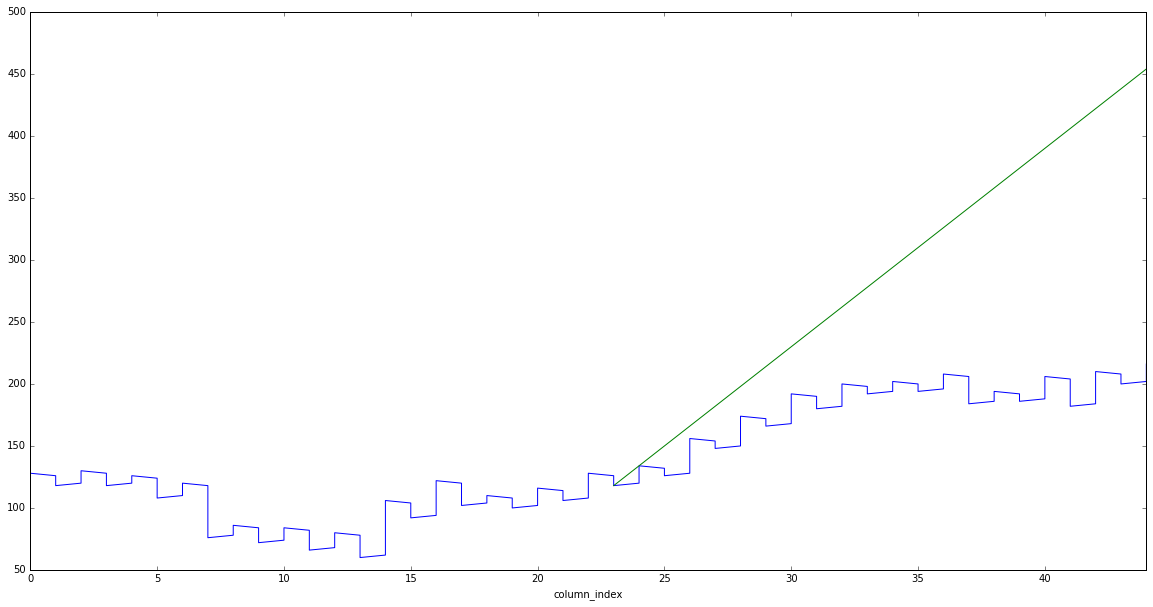

In [89]:
pnf_df = pd.DataFrame(temp_l)                
pnf_df.index = pnf_df.column_index
#pnf_df.groupby(pnf_df.index).las().close.plot()

pnf_df['test_trendline'] = np.array([np.NaN] * len(pnf_df.index))
pnf_df.test_trendline[23] = pnf_df.close[23]
pnf_df.test_trendline[24] = pnf_df.close[24]

pnf_df.test_trendline = pnf_df.test_trendline.groupby(pnf_df.test_trendline.index).last().interpolate('barycentric')

figsize(20,10)
pnf_df.close.plot()
pnf_df.test_trendline.plot()

In [77]:
pnf_df.test_trendline.groupby(pnf_df.test_trendline.index).last()

column_index
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
       ...  
125      NaN
126      NaN
127      NaN
128      NaN
129      NaN
130      NaN
131      NaN
132      NaN
133      NaN
134      NaN
135      NaN
136      NaN
137      NaN
138      NaN
139      NaN
140      NaN
141      NaN
142      NaN
143      NaN
144      NaN
145      NaN
146      NaN
147      NaN
148      NaN
149    16.75
150    20.75
151      NaN
152      NaN
153      NaN
154      NaN
Name: test_trendline, dtype: float64

In [36]:
pnf_df['test_trendline'] = np.array([np.NaN] * len(pnf_df.index))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [69]:
pnf_df

,close,column_index,date,open,type,test_trendline
column_index,,,,,,
0,71.75,0,2006-04-19,70.75,x,NaN
0,72.75,0,2006-04-21,71.75,x,NaN
1,71.75,1,2006-04-25,72.75,o,NaN
1,70.75,1,2006-04-25,71.75,o,NaN
1,69.75,1,2006-04-26,70.75,o,NaN
1,68.75,1,2006-04-27,69.75,o,NaN
2,69.75,2,2006-05-01,68.75,x,NaN
2,70.75,2,2006-05-01,69.75,x,NaN
2,71.75,2,2006-05-02,70.75,x,NaN


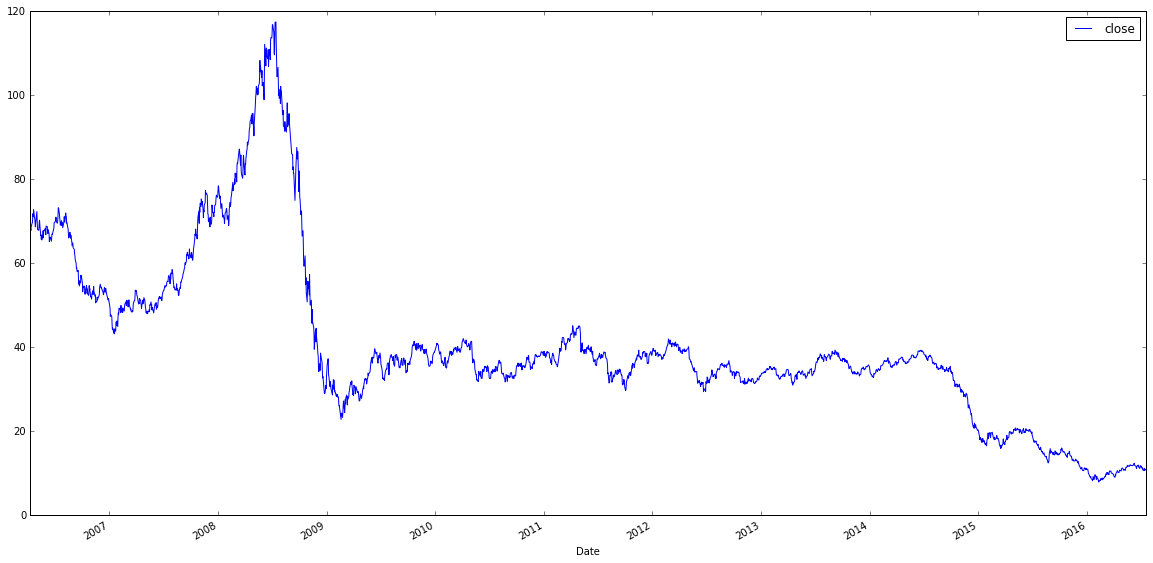

In [21]:
df.plot()

In [90]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

py.sign_in('tmqr', '8rctfyu197')


trace1 = go.Scatter(
    x = pnf_df[pnf_df.type == 'o'].index,
    y = pnf_df[pnf_df.type == 'o'].close,
    name='Down',
    mode = 'markers',
    marker = dict(symbol="o", size=5, color = 'rgba(255, 0, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'o'].date
)

trace2 = go.Scatter(
    x = pnf_df[pnf_df.type == 'x'].index,
    y = pnf_df[pnf_df.type == 'x'].close,
    name = 'Up',
    mode = 'markers',
    marker = dict(symbol="x", size=5, color = 'rgba(0, 255, 0, 0.9)'),
    text = pnf_df[pnf_df.type == 'x'].date
)

xo = [trace1, trace2]

layout = go.Layout(
    title="Point And Figure",
    xaxis=dict( autotick=True, autorange=True
        )
    )
fig = go.Figure(data=xo, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [8]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')